In [1]:
import os
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import r2_score
import sqlite3
from sklearn.preprocessing import StandardScaler
from tslearn.clustering import TimeSeriesKMeans 

# Liste des fonctions

## f_requete_sql - Requete SQL

In [2]:
def f_requete_sql (requete) :
    try:
        connexion = sqlite3.connect('../data/liste_piezos.db')
        curseur = connexion.cursor()
        print("Connexion réussie à SQLite")
        curseur.execute(requete)
        connexion.commit()
        resultat = curseur.fetchall()
        curseur.close()
        connexion.close()
        print("Connexion SQLite est fermée")
        return resultat
    except sqlite3.Error as error:
        print("Erreur lors du mis à jour dans la table", error)

## f_clusters_transform - Fonction conversion df en np.array

In [3]:
def f_clusters_transform (df):
    """
    df : dataframe pandas
    """
    data = df.values.T
    names = df.columns
    return(data, names)

## f_clusters_coude - Fonction d'affichage de l'inertie en fonction du nombre de clusters

In [41]:
def f_clusters_coude (df, k_max:int=15):
    """
    k_max : entier représentant le nombre max de clusters à tracer
    """
    data, names = f_clusters_transform(df)
    Sum_of_squared_distances = [] 
    K = range(1,k_max) 
    for k in K : 
        km = KMeans(n_clusters=k) 
        km = km.fit(data) 
        Sum_of_squared_distances.append(km.inertia_)

    plt.plot(K, Sum_of_squared_distances, 'bx-') 
    plt.xlabel('k') 
    plt.ylabel('Sum_of_squared_distances') 
    plt.title('Méthode du coude pour k optimal') 
    plt.show()


## f_clusters_fit - Fonction entrainement du modèle, retour des labels et profils clusters

In [5]:
def f_clusters_fit (df, k:int = 4, n_init:int = 200, max_iter:int = 1000):
    """
    Entrainement et affichage de la distribution dans les clusters
    return :
    - cluster_table : df bss - cluster - r2
    - df_clusters_centers : df série temporelle des clusters
    """
    data, names = f_clusters_transform (df)
    km = KMeans(n_clusters=k, n_init=200, max_iter=1000, random_state=2022)
    # Entraînement du modèle
    km.fit(data)
    # Définition des numéros de cluster
    labels = km.labels_+1
    # Profils des clusters
    cluster_centers = np.array(km.cluster_centers_)
    df_cluster_centers = pd.DataFrame(cluster_centers.T, index=df.index)
    for cluster in range(df_cluster_centers.shape[1]):
        df_cluster_centers.rename(columns = {cluster:f"cluster_{cluster+1}"}, inplace=True)
    
    # Création du dataframe de résultats
    cluster_table = pd.DataFrame()
    cluster_table["code_bss"] = names
    cluster_table.set_index("code_bss", inplace=True)
    cluster_table["cluster"] = labels
    for piezo in cluster_table.index :
        cluster_table.loc[piezo, "r2"] = r2_score(df.loc[:,piezo], cluster_centers[cluster_table.loc[piezo, "cluster"]-1])
    
    return cluster_table, df_cluster_centers

## f_plot_clusters - Fonction d'affichage des chroniques par cluster

In [6]:
def f_plot_clusters (df, cluster_table, cluster_centers):
    
    data, names = f_clusters_transform (df)
    
    labels = cluster_table["cluster"]
    
    fig, axs = plt.subplots(len(set(labels)),1,figsize=(20,25))
    row_i=0

    for label in set(labels):
        for i in range(len(labels)):
            if(labels[i]==label):
                axs[row_i].plot(df.iloc[:,i],alpha=0.4)

        axs[row_i].plot(cluster_centers.iloc[:,label-1],c="red")
        axs[row_i].set_title("Cluster "+str(row_i+1))
        row_i+=1
    plt.show()

## f_plot_all - Fonction d'affichage individuel des chroniques et leur cluster associé

In [7]:
def f_plot_all (df, cluster_table, df_cluster_centers) :

    data, names = f_clusters_transform (df)

    if df.shape[1]%4 == 0:
        nbre_lignes = df.shape[1]//4
    else : 
        nbre_lignes = df.shape[1]//4 + 1

    fig, axs = plt.subplots(nbre_lignes,4,figsize=(25,200))
    #fig.suptitle('Series')
    for i in range(nbre_lignes):
        for j in range(4):
            if i*4+j+1>df.shape[1]: # pass the others that we can't fill
                continue
            axs[i, j].plot(df.iloc[:,i*4+j])
            axs[i, j].plot(df_cluster_centers.iloc[:,cluster_table.iloc[i*4+j,0]-1])
            
            axs[i, j].set_title(df.columns[i*4+j] + f" - r² = {round(cluster_table.loc[df.columns[i*4+j],'r2'],2)}")
            
    plt.show()

## f_r2min - Fonction de calcul du seuil minimal r2

In [8]:
def f_r2min (cluster_table):
    # Calcul de r2min

    Q1 = cluster_table["r2"].quantile(0.25, "higher")
    Q3 = cluster_table["r2"].quantile(0.75, "lower")

    # Ecart inter-quartile
    IQM = (Q3-Q1)

    # Seuil minimal de conservation des chroniques (Q1-1.5*IQM)

    r2min = Q1-1.5*IQM
    return r2min

# Exploitation - 1ère passe

## Chargement des données

Les données sont récoltées à partir des csv créés lors du nettoyage et la sélection des piezos avec le moins de données manquantes et la plus longue plage de temps possible.

In [33]:
region = "CVL"

# Import du csv et conversion en dataframe
custom_date_parser = lambda x: datetime.strptime(x, "%Y-%m-%d")
data = pd.read_csv(f"./data/{region}.csv", sep = ";", parse_dates=True, index_col="date_mesure", date_parser=custom_date_parser)

## Analyse du nombre optimal de clusters

C:\Users\daranlot\Anaconda3\envs\Environnement\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


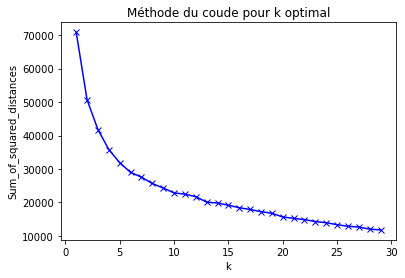

In [34]:
f_clusters_coude(data)

## Création des clusters

In [11]:
# Choix du nombre de clusters à créer
nbre_clusters = 6

C:\Users\daranlot\Anaconda3\envs\Environnement\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


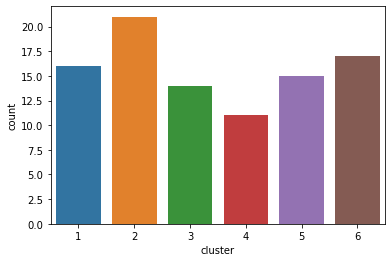

In [12]:
# Entrainement
cluster_table, cluster_centers = f_clusters_fit(data, nbre_clusters, 500, 5000)

# répartition des piezos dans les clusters
sns.countplot(cluster_table.cluster)
# On renomme les noms de cluster par rapport à la région
for index, column in enumerate (cluster_centers.columns):
    cluster_centers.rename(columns={column : f"{region}_{index+1}"}, inplace=True)

In [13]:
cluster_table.head()

cluster        r2
code_bss                            
05445X0081_P1            2  0.885599
03627X0052_P1            6  0.878610
05475X0057_P1            2  0.474575
04915X0009_F1AEP1        2  0.687805
04265X0012_FAEP1         4  0.725246

## Affichage des clusters

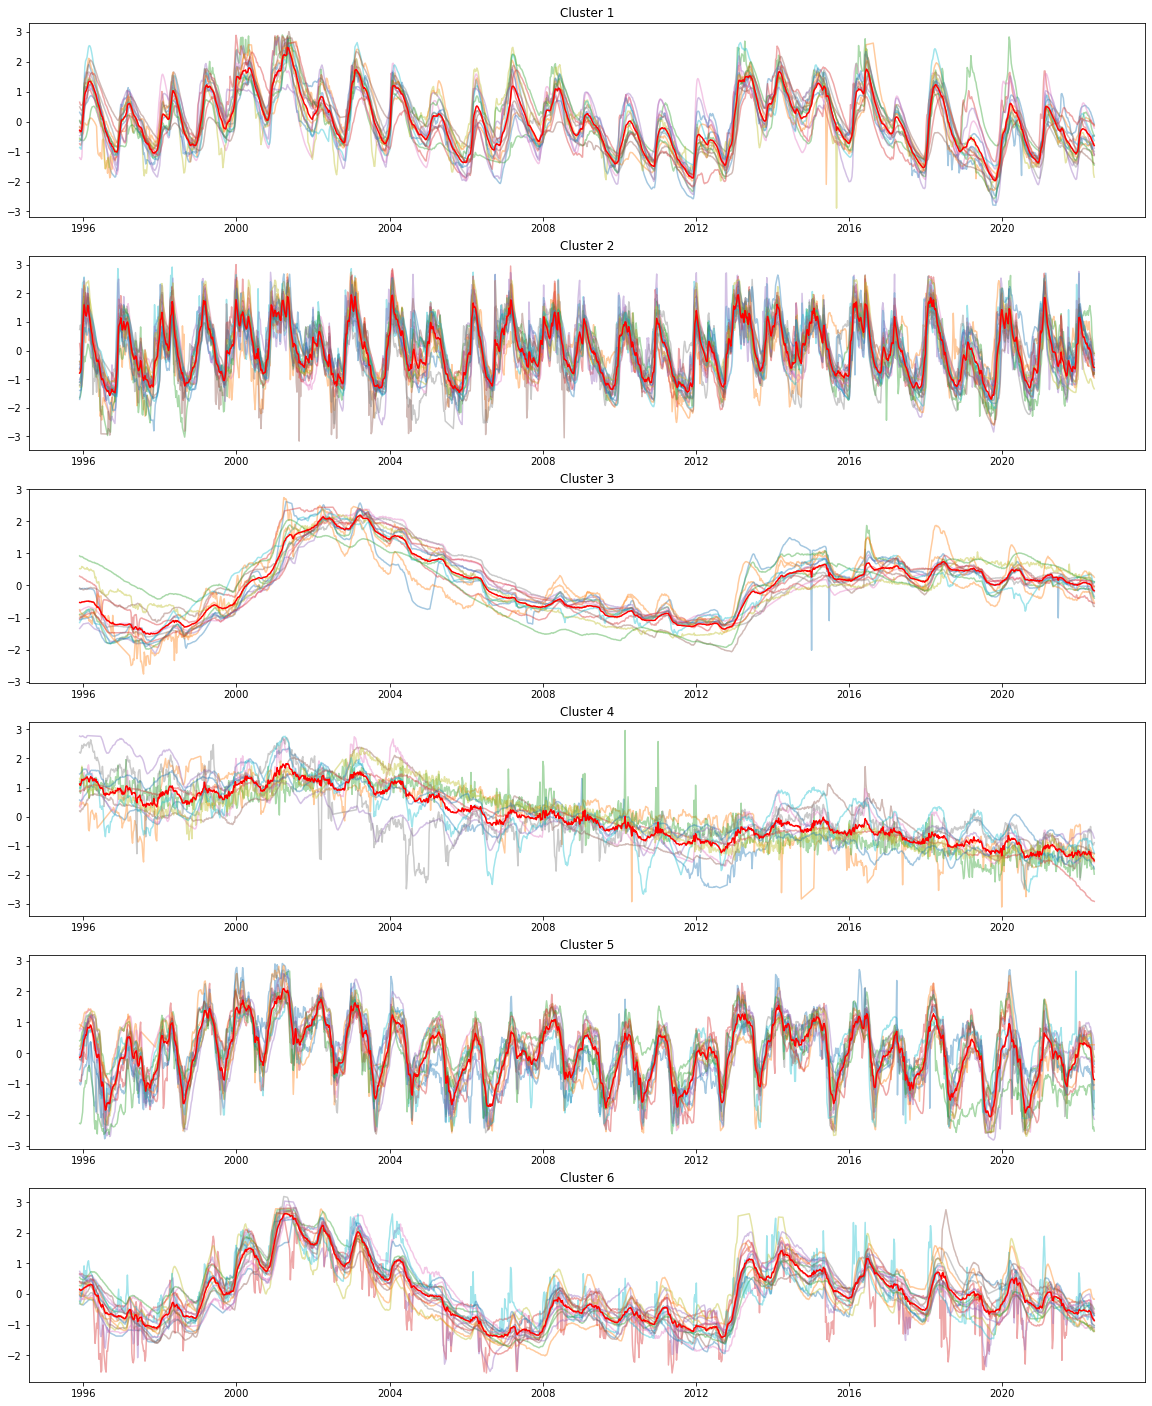

In [14]:
f_plot_clusters(data, cluster_table, cluster_centers)

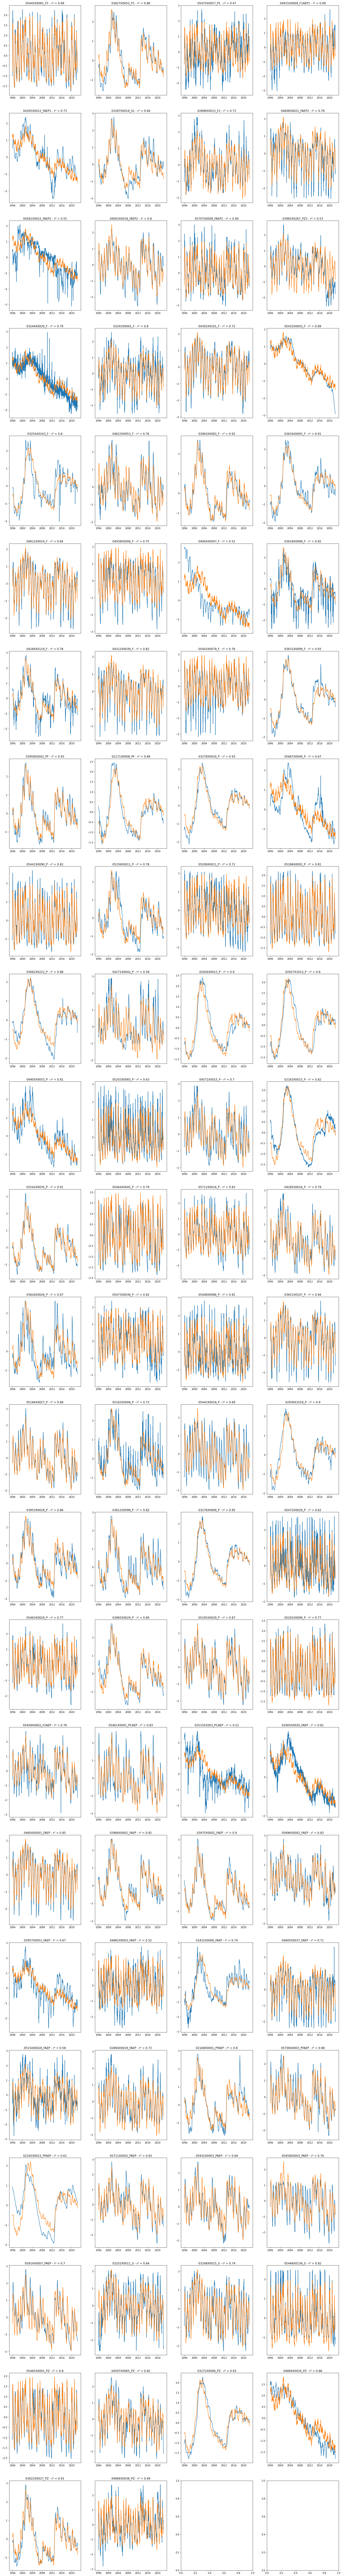

In [15]:
f_plot_all(data, cluster_table, cluster_centers)

In [16]:
cluster_table.groupby("cluster").mean()

r2
cluster          
1        0.771875
2        0.743708
3        0.862769
4        0.709554
5        0.740280
6        0.834346

## Filtre des chroniques avec score insuffisant

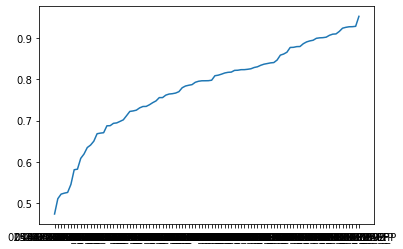

In [17]:
plt.plot(cluster_table["r2"].sort_values())

Itération 1 : 2 chronique(s) éliminée(s).
Itération 2 : 0 chronique(s) éliminée(s).


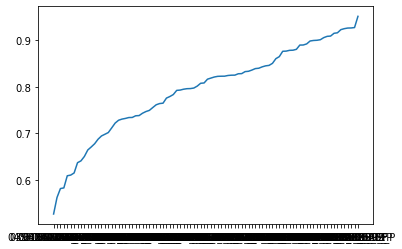

In [18]:
# nbre de chroniques sous le seuil
r2min = f_r2min(cluster_table)
nbre_elim = cluster_table.loc[cluster_table.r2 < r2min, 'r2'].count()
iteration = 1

while nbre_elim != 0 :
    # chroniques sous le seuil passées à cluster 0
    r2min = f_r2min(cluster_table)
    cluster_table.loc[cluster_table.r2 < r2min, "cluster"] = 0
    
    # Selection des clusters non zéro
    data = data.loc[:,cluster_table.loc[cluster_table.cluster != 0].index]
    
    # Nouveau clustering
    cluster_table, cluster_centers = f_clusters_fit(data, nbre_clusters, 500, 5000)
    
    nbre_elim = cluster_table.loc[cluster_table.r2 < r2min, 'r2'].count()
    
    print(f"Itération {iteration} : {nbre_elim} chronique(s) éliminée(s).")
    iteration += 1

plt.plot(cluster_table["r2"].sort_values())

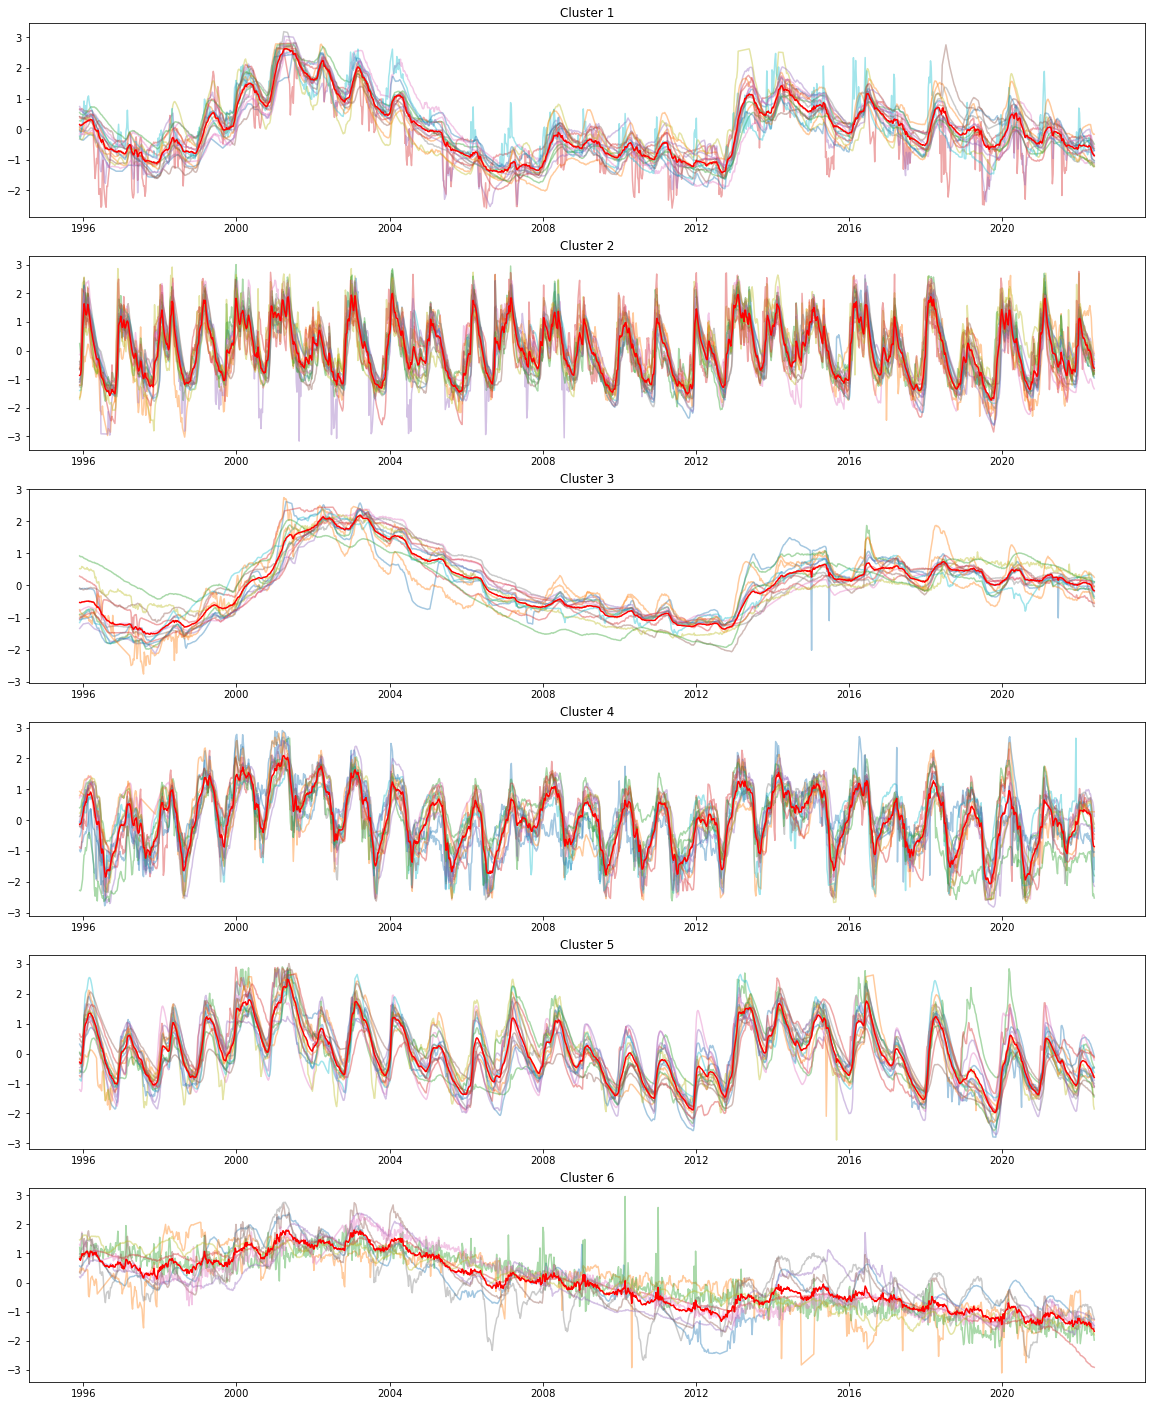

In [19]:
f_plot_clusters(data, cluster_table, cluster_centers)

In [20]:
cluster_table.groupby("cluster").mean()

r2
cluster          
1        0.834346
2        0.772765
3        0.862769
4        0.740280
5        0.771875
6        0.771621

# Prédiction des autres piezos

Récupération de l'ensemble des codes_bss de la région depuis la base de données. 

In [21]:
requete = f"""
        SELECT code_bss
        FROM data_piezo
        INNER JOIN code_region
            ON code_dpt = departement
        WHERE code_region IS '{region}'
        AND fichier_piezo IS 1
         """

code_bss = [code[0] for code in f_requete_sql(requete)]

    
# Les chroniques des piezos sont assemblées en un dataframe Pandas.

directory = '../data/piezo/'

Connexion réussie à SQLite
Connexion SQLite est fermée


In [37]:
print(f"Création du dataframe avec {len(code_bss)} piézomètres.")

# Lecture des données du premier piezo de la liste pour initialiser le dataframe
data = pd.read_csv(directory+f"{code_bss[0]}.csv", sep=";",  index_col=0, parse_dates=True)
data.rename(columns={"piezo":f"{code_bss[0]}"}, inplace=True)
# Mise en forme de la date en Y - W
data.index = data.index.strftime("%Y - S%W")
# Moyenne des mesures pour une même semaine
data = pd.DataFrame(data.groupby("date_mesure").mean())

print(f"Chargement des données à partir des fichiers csv.")

custom_date_parser = lambda x: datetime.strptime(x, "%Y-%m-%d")
for file in code_bss[1:]:
    df = pd.read_csv(f"{directory+file}.csv", sep=";",  index_col=0, parse_dates=True, date_parser=custom_date_parser)
    df.rename(columns={"piezo":f"{file}"}, inplace=True)
    # Mise en forme de la date en Y - W
    df.index = df.index.strftime("%Y - S%W")
    # Moyenne des mesures pour une même semaine
    df = pd.DataFrame(df.groupby("date_mesure").mean())
    data = pd.merge(data, df, left_index=True, right_index=True, how='outer')
    data = data.interpolate()

print(f"Suppression des valeurs abbérantes.")   
    
# Suppression des valeurs abbérantes
for piezo in data.columns : 
    q1 = np.nanquantile(data[f"{piezo}"], .25)
    q3 = np.nanquantile(data[f"{piezo}"], .75)
    IQR = q3-q1
    data.loc[data[f"{piezo}"] < (q1-1.5*IQR), piezo] = np.NaN
    data.loc[data[f"{piezo}"] > (q3+1.5*IQR), piezo] = np.NaN
    
print(f"Normalisation des données.")    

# Normalisation

def scaleColumns(df):
    for col in df.columns:
        df[col] = pd.DataFrame(scaler.fit_transform(pd.DataFrame(df[col])),columns=[col], index=df.index)
    return df

scaler = StandardScaler()
data = scaleColumns(data)

print("Création du dataframe de résultats.")

big_clustering = pd.DataFrame(index=data.columns, columns=["cluster"])

# Mise en forme des chroniques calculées des clusters au même format Y - W

cluster_centers_S = cluster_centers.copy()
cluster_centers_S.index = cluster_centers_S.index.strftime("%Y - S%W")

print("Entrainement et clusterisation en cours.")

# Initialisation du modèle
# random_state permet de conserver le même ordre de sortie des labels pour l'entrainement
knn =  KMeans(n_clusters=nbre_clusters, n_init=200, max_iter=1000, random_state=2022)

# Pour chaque piézo, une jointure interne est réalisée entre la chronique du piezo (sans les NaN) et les chroniques calculées 
for piezo in data.columns:
    df_merge = pd.DataFrame()
    df_merge = pd.merge(data[piezo].dropna(), cluster_centers_S, how='inner', left_index=True, right_index=True)
    # Interpolation en cas de caleurs manquantes
    df_merge = df_merge.interpolate('linear')
    # Transformation en tableau numpy et récupération des codes_bss
    X, names = f_clusters_transform(df_merge)
    # Entrainement du modèle
    knn.fit(X[1:])
    # Prédiction sur les données du piezo
    y = X[0].reshape(1,-1)
    big_clustering.loc[piezo,"cluster"] = knn.predict(y)[0]+1 #indice [0] pour récupérer une valeur et non un tableau

print("====== Clusterisation terminée ======")

Création du dataframe avec 185 piézomètres.
Chargement des données à partir des fichiers csv.
Suppression des valeurs abbérantes.
Normalisation des données.
Création du dataframe de résultats.
Entrainement et clusterisation en cours.
====== Clusterisation terminée ======


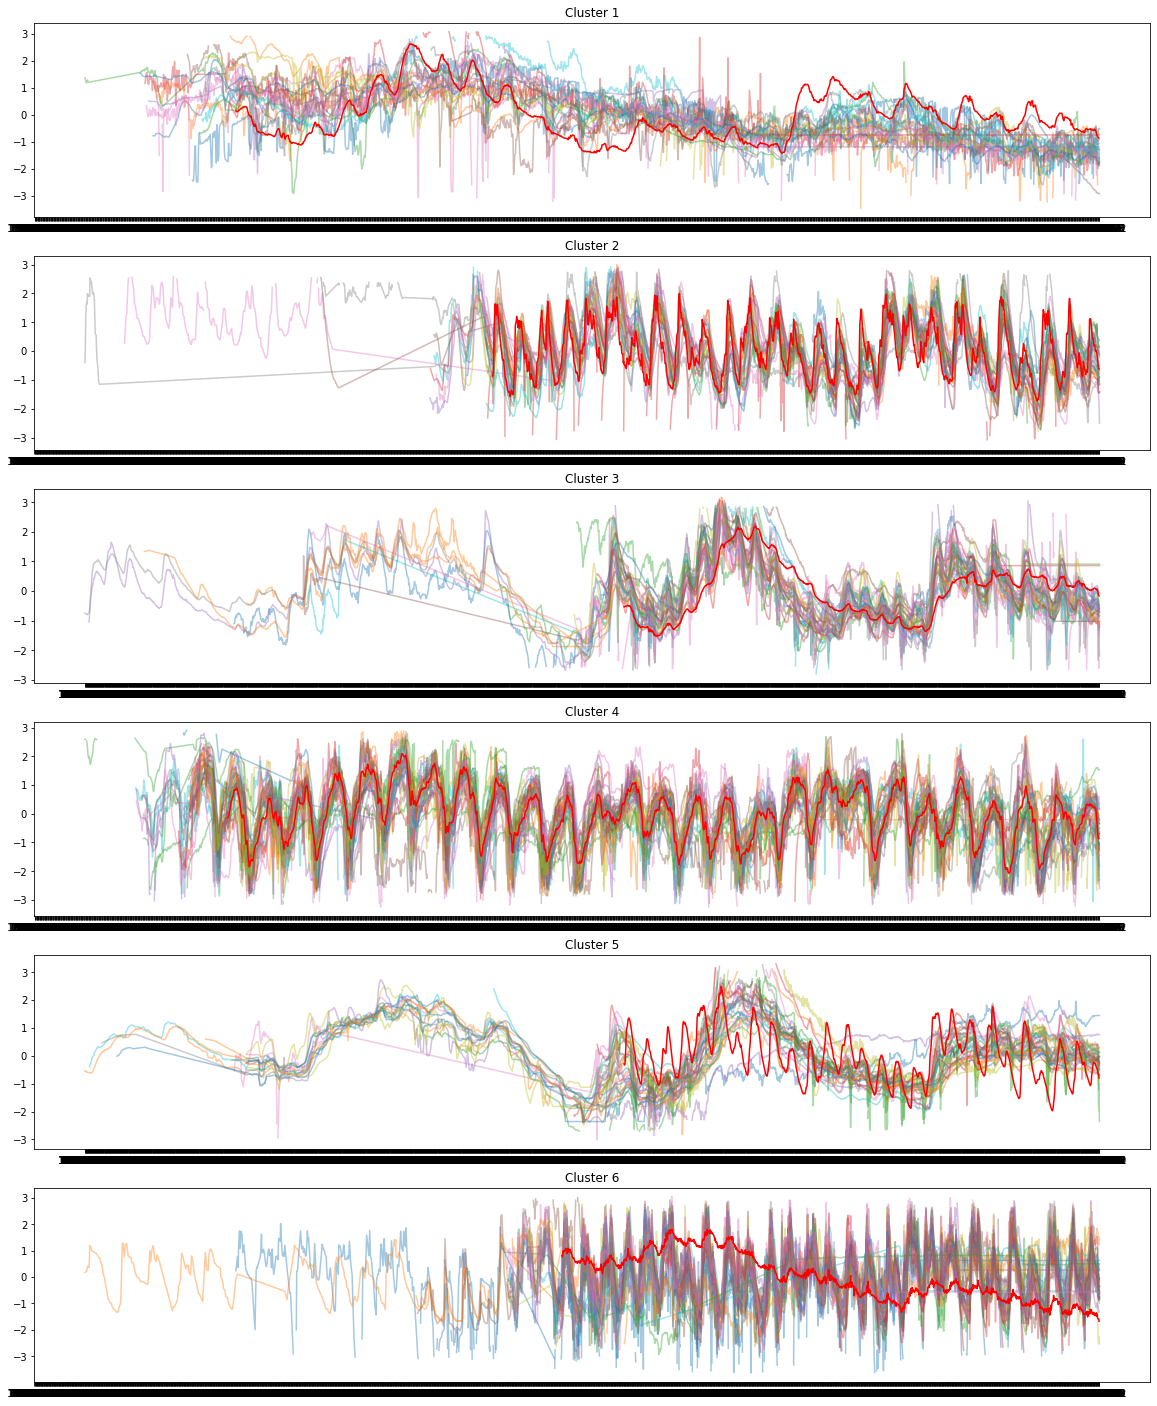

In [40]:
f_plot_clusters(data, big_clustering, cluster_centers_S)

# Ajout à la bdd

In [24]:
requete = """
                    ALTER TABLE data_piezo
                    ADD cluster_kmeans_ALL VARCHAR(6) DEFAULT NULL
                    """
f_requete_sql(requete)

Connexion réussie à SQLite
Erreur lors du mis à jour dans la table duplicate column name: cluster_kmeans_ALL


In [25]:
# Création de listes de nuéro de cluster avec le nom des piezos
# Ajout dans la bdd
for label in set(big_clustering.cluster):
    exec(f"cluster = tuple(big_clustering.loc[big_clustering.cluster == '{label}', 'cluster'].index.to_list())")
    requete = f"""
        UPDATE data_piezo
        SET cluster_kmeans_ALL = '{label}'
        WHERE code_bss IN {cluster}
        """
    f_requete_sql(requete)

Connexion réussie à SQLite
Connexion SQLite est fermée
Connexion réussie à SQLite
Connexion SQLite est fermée
Connexion réussie à SQLite
Connexion SQLite est fermée
Connexion réussie à SQLite
Connexion SQLite est fermée
Connexion réussie à SQLite
Connexion SQLite est fermée
Connexion réussie à SQLite
Connexion SQLite est fermée


## Suppresion colonne

In [ ]:
requete = """
                    ALTER TABLE data_piezo
                    DROP cluster_kmeans_ALL
                    """
f_requete_sql(requete)